# Optimal Fund Portfolio Return (STRAT)

I focus exclusively on value-weighted portfolios, as equal-weighted portfolios implicitly represent active trading strategies that would incur significant transaction costs. Additionally, since my simple momentum factor does not produce satisfactory results, I will retain only the Betting-against-Beta (BaB) and Idiosyncratic Volatility (IV) factors.

We consider a fund that invests in 1-month T-Bills and applies an overlay on factor strategies (BaB, IV, MoM) targeting an annualized volatility of 10\%. 

The fund return is defined as
$$
R_{\text{fund}} = R_{\text{T-Bill}} + c \cdot R_{\text{STRAT}},
$$
where $R_{\text{STRAT}}$ is the return of the combined factor strategies and $c$ is a scaling factor chosen to achieve the target volatility. 

Three combination approaches are considered: 
(1) equal-weighted, 
(2) risk-parity based on rolling volatilities, and 
(3) mean-variance optimal based on the rolling mean-covariance matrix. 

Performance is evaluated in terms of annualized mean, standard deviation, and Sharpe ratio, with the risk-parity approach retained for subsequent analysis.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import CSV des facteurs value-weighted
BAB_factor = pd.read_csv('BAB_factor_VW.csv', parse_dates=['date'])
IV_factor = pd.read_csv('IV_factor_VW.csv', parse_dates=['date'])
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])


# Vérifier
print(BAB_factor.head())
print(IV_factor.head())


        date   BAB_ret
0 1967-02-28  0.017182
1 1967-06-30 -0.009111
2 1967-08-31  0.016276
3 1967-11-30  0.004028
4 1968-02-29 -0.021424
        date    IV_ret
0 1970-01-31 -0.096587
1 1970-02-28 -0.000711
2 1970-03-27  0.012791
3 1970-04-30 -0.047982
4 1970-05-30 -0.138104


In [2]:
strategies = pd.merge(BAB_factor, IV_factor, on='date', how='inner')
strategies.rename(columns={'IV_ret':'IV'}, inplace=True)
strategies.rename(columns={'BAB_ret':'BAB'}, inplace=True)

# On ne garde que value-weighted, pas de MOM
strategies = strategies[['date','BAB','IV']]

rf = data[['date','rf']].drop_duplicates()
strategies = strategies.merge(rf, on='date', how='left')

target_vol = 0.10

# Equal Weighted

In [3]:
strategies['STRAT_EQ'] = strategies[['BAB','IV']].mean(axis=1)
vol_eq = strategies['STRAT_EQ'].std() * np.sqrt(12)
c_eq = target_vol / vol_eq
strategies['STRAT_EQ_scaled'] = c_eq * strategies['STRAT_EQ']

# Risk Parity

In [4]:
rolling_vol = strategies[['BAB','IV']].rolling(window=12).std()
weights_rp = 1 / rolling_vol
weights_rp = weights_rp.div(weights_rp.sum(axis=1), axis=0)
strategies['STRAT_RP'] = (strategies[['BAB','IV']] * weights_rp[['BAB','IV']]).sum(axis=1)
vol_rp = strategies['STRAT_RP'].std() * np.sqrt(12)
c_rp = target_vol / vol_rp
strategies['STRAT_RP_scaled'] = c_rp * strategies['STRAT_RP']

# Mean Variance Optimal 

In [5]:
mean_ret = strategies[['BAB','IV']].mean() * 12
cov_mat = strategies[['BAB','IV']].cov() * 12
inv_cov = np.linalg.inv(cov_mat)
weights_mv = inv_cov.dot(mean_ret)
weights_mv /= weights_mv.sum()
strategies['STRAT_MV'] = (strategies[['BAB','IV']] * weights_mv).sum(axis=1)
vol_mv = strategies['STRAT_MV'].std() * np.sqrt(12)
c_mv = target_vol / vol_mv
strategies['STRAT_MV_scaled'] = c_mv * strategies['STRAT_MV']


In [6]:
strategies['Fund_EQ'] = strategies['rf'] + strategies['STRAT_EQ_scaled']
strategies['Fund_RP'] = strategies['rf'] + strategies['STRAT_RP_scaled']
strategies['Fund_MV'] = strategies['rf'] + strategies['STRAT_MV_scaled']

In [7]:
print("Annualized mean returns:")
print("EQ:", strategies['Fund_EQ'].mean()*12)
print("RP:", strategies['Fund_RP'].mean()*12)
print("MV:", strategies['Fund_MV'].mean()*12)

print("\nAnnualized volatilities:")
print("EQ:", strategies['Fund_EQ'].std()*np.sqrt(12))
print("RP:", strategies['Fund_RP'].std()*np.sqrt(12))
print("MV:", strategies['Fund_MV'].std()*np.sqrt(12))

Annualized mean returns:
EQ: 0.16884940450778463
RP: 0.17669318263429046
MV: 0.16963390900309266

Annualized volatilities:
EQ: 0.10077022074107919
RP: 0.10052457637640237
MV: 0.10075350019706686


In [8]:
# Nombre de mois
N = len(strategies)

# Fonction pour t-stat annualisé
def annualized_t_stat(ret_series):
    mean_m = ret_series.mean()
    std_m = ret_series.std()
    t_stat = mean_m / (std_m / np.sqrt(N))
    return t_stat

# Calcul des t-stats
t_eq = annualized_t_stat(strategies['Fund_EQ'])
t_rp = annualized_t_stat(strategies['Fund_RP'])
t_mv = annualized_t_stat(strategies['Fund_MV'])

print("T-statistics for mean monthly returns:")
print("EQ:", t_eq)
print("RP:", t_rp)
print("MV:", t_mv)


T-statistics for mean monthly returns:
EQ: 7.430750884972254
RP: 7.794942577914457
MV: 7.466514380518077


very significative


In [9]:
# Annualized Sharpe ratios
sharpe_eq = strategies['Fund_EQ'].mean()/strategies['Fund_EQ'].std()*np.sqrt(12)
sharpe_rp = strategies['Fund_RP'].mean()/strategies['Fund_RP'].std()*np.sqrt(12)
sharpe_mv = strategies['Fund_MV'].mean()/strategies['Fund_MV'].std()*np.sqrt(12)

print("Annualized Sharpe ratios:")
print("EQ:", sharpe_eq)
print("RP:", sharpe_rp)
print("MV:", sharpe_mv)

strategies.to_csv('strategies.csv')


Annualized Sharpe ratios:
EQ: 1.67558831633037
RP: 1.75771128815986
MV: 1.6836527631427243


Going forward we keep the RP strategy

# Performance and risk analysis for the Fund strategy

In [10]:
import pandas as pd


ind = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows=4)
nd = ind.iloc[:-1].copy()


ind['date_str'] = ind['Unnamed: 0'].astype(str).str.strip()
ind = ind[ind['date_str'].str.isdigit() & (ind['date_str'].str.len() == 8)].copy()


ind['date'] = ind['date_str'].apply(lambda x: pd.Timestamp(
    year=int(x[:4]), month=int(x[4:6]), day=int(x[6:8])
))


ind = ind.drop(columns=['Unnamed: 0','date_str'])

ind.to_csv('ff5.csv')



In [11]:
import pandas as pd


ind = pd.read_csv('12_Industry_Portfolios_Daily.csv', skiprows=9)


ind = ind.iloc[:-1].copy()


ind['date_str'] = ind['Unnamed: 0'].astype(str).str.strip()
ind = ind[ind['date_str'].str.isdigit() & (ind['date_str'].str.len() == 8)].copy()


ind['date'] = ind['date_str'].apply(lambda x: pd.Timestamp(
    year=int(x[:4]), month=int(x[4:6]), day=int(x[6:8])
))


ind = ind.drop(columns=['Unnamed: 0','date_str'])
ind.to_csv('Industries.csv')


In [12]:
ff5 = pd.read_csv('ff5.csv')
industries = pd.read_csv('Industries.csv')
strategies = pd.read_csv('strategies.csv')

In [13]:
import pandas as pd


industries['date'] = pd.to_datetime(industries['date'])
ff5['date'] = pd.to_datetime(ff5['date'])
strategies['date'] = pd.to_datetime(strategies['date'])


industries_monthly = industries.set_index('date').resample('M').last().reset_index()


ff5_monthly = ff5.set_index('date').resample('M').last().reset_index()


df = strategies.merge(industries_monthly, on='date', how='left')
df = df.merge(ff5_monthly, on='date', how='left')
df = df.dropna()
df = df.drop(columns='Unnamed: 0_x')


/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24378/595266288.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  industries_monthly = industries.set_index('date').resample('M').last().reset_index()
/var/folders/s3/w3_938yj6mb4c7_8trrtc56h0000gn/T/ipykernel_24378/595266288.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff5_monthly = ff5.set_index('date').resample('M').last().reset_index()


Compute exposure

In [14]:
import statsmodels.api as sm


industries_cols = [col for col in industries_monthly.columns if col != 'date']
ff5_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']


X = df[industries_cols + ff5_cols]


X = sm.add_constant(X)


y = df['Fund_RP']


model = sm.OLS(y, X).fit()

# Résultats
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                Fund_RP   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2.085
Date:                Sun, 16 Nov 2025   Prob (F-statistic):            0.00798
Time:                        19:13:44   Log-Likelihood:                 442.66
No. Observations:                 201   AIC:                            -847.3
Df Residuals:                     182   BIC:                            -784.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0204      0.005      3.952      0.0

Fund_RP Factor Regression Analysis:
The strategy exhibits significant positive exposure to the market factor.
There is a significantly negative exposure to the Financial Services industry (Money), while other industry exposures are small or not statistically significant.
The alpha of the strategy is 2.04% per month, which annualizes to roughly 24.5%, indicating that the majority of the expected return is not explained by the market or industry factors.
The R-squared is 17.1%, showing that industry and market factors explain only a modest portion of the strategy’s return variation.
Conclusion: The Fund_RP strategy generates substantial risk-adjusted returns that cannot be fully explained by traditional industry and market exposures, highlighting the presence of true alpha.

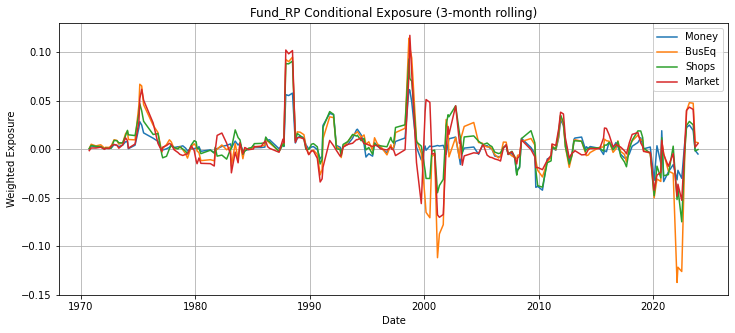

In [15]:

Exposures = df.copy()
Exposures[industries_cols] = Exposures[industries_cols].multiply(Exposures['Fund_RP'], axis=0)


Exposures['beta_Mkt'] = Exposures['Fund_RP'] * Exposures['Mkt-RF']


import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
for col in ['Money', 'BusEq', 'Shops']: 
    plt.plot(Exposures['date'], Exposures[col].rolling(3).mean(), label=col)
plt.plot(Exposures['date'], Exposures['beta_Mkt'].rolling(3).mean(), label='Market')
plt.title('Fund_RP Conditional Exposure (3-month rolling)')
plt.xlabel('Date')
plt.ylabel('Weighted Exposure')
plt.legend()
plt.grid(True)
plt.show()
